# Interactive Beam Example

self link: go/interactive-beam-example

## Blaze run the notebook kernel
```
google3$ blaze run pipeline/dataflow/python/interactive:beam_notebook.par
```

## Running on local machine (Direct Runner)

This is a very simple example of how to use Interactive Runner.


In [1]:
import apache_beam as beam
from apache_beam.runners.interactive import interactive_runner
from apache_beam.runners.direct import direct_runner

In [2]:
%matplotlib inline

### The initial run

In [23]:
runner = interactive_runner.InteractiveRunner(
    render_option='graph', cache_format="tfrecord")  # render_option could also be 'mute', 'text'
p = beam.Pipeline(runner=runner)

In [24]:
pcoll_init = p | beam.Create(range(10))
squares = pcoll_init | 'Square' >> beam.Map(lambda x: x*x)
cubes = pcoll_init | 'Cube' >> beam.Map(lambda x: x**3)
result = p.run()

Running...

Using 0 cached PCollections
Executing 3 of 3 transforms.

Cube produced {343, 0, 512, 729, 1, ...}

Square produced {16, 64, 25, 49, 9, ...}

Create produced {8, 9, 2, 3, 0, ...}

### Fetching PCollection
You can fetch PCollection from the result as a list.

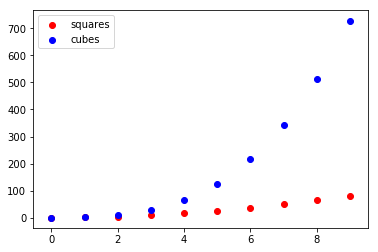

In [25]:
init_list = list(range(10))
squares_list = result.get(squares)
cubes_list = result.get(cubes)

squares_list.sort()
cubes_list.sort()

from matplotlib import pyplot as plt
plt.scatter(init_list, squares_list, label='squares', color='red')
plt.scatter(init_list, cubes_list, label='cubes', color='blue')
plt.legend(loc='upper left')
plt.show()

### Hack with the pipeline and run Round 2

In [26]:
class AverageFn(beam.CombineFn):
  def create_accumulator(self):
    return (0.0, 0)

  def add_input(self, sum_count, input):
    (sum, count) = sum_count
    return sum + input, count + 1

  def merge_accumulators(self, accumulators):
    sums, counts = zip(*accumulators)
    return sum(sums), sum(counts)

  def extract_output(self, sum_count):
    (sum, count) = sum_count
    return sum / count if count else float('NaN')

In [27]:
average_squares = squares | 'AverageSquares' >> beam.CombineGlobally(AverageFn())
result = p.run()

Running...

Using 2 cached PCollections
Executing 1 of 4 transforms.

Cube produced {343, 0, 512, 729, 1, ...}

Square produced {16, 64, 25, 49, 9, ...}

AverageSquares produced {28.5}

In [29]:
average_cubes = cubes | 'AverageCubes' >> beam.CombineGlobally(AverageFn())
result = p.run()

RuntimeError: Transform "AverageCubes" does not have a stable unique label. This will prevent updating of pipelines. To apply a transform with a specified label write pvalue | "label" >> transform

## Running on Flume


In [ ]:
from google3.pipeline.flume.py import runner as flume_runner

In [ ]:
from absl import flags
FLAGS = flags.FLAGS

FLAGS.flume_exec_mode  = 'BORG'  # Use for larger wordloads (say, much much much larger than Shakespeare wordcount)
# FLAGS.flume_exec_mode = 'LOCAL_PROCESSES'  # Use for smaller worklaods

You can choose to keep the caches on local disk or on CNS.

In [ ]:
cache_dir = '/cns/path/to/dir/cache'
underlying_runner = flume_runner.FlumeRunner()
runner = interactive_runner.InteractiveRunner(
    underlying_runner=underlying_runner,
    cache_dir=cache_dir,
    render_option='graphviz-server'
)

runner.start_session()

In [ ]:
class WordExtractingDoFn(beam.DoFn):
  def process(self, element):
    return element.split()
  
def count_ones(word_ones):
  (word, ones) = word_ones
  return (word, sum(ones))

In [ ]:
p = beam.Pipeline(runner=runner)
counts = (p
          | 'Read' >> beam.io.ReadFromText(
               '/placer/test/home/flume/text/shakespeare/winterstale')
          | 'Split' >> beam.ParDo(WordExtractingDoFn())
          | 'Pair With One' >> beam.Map(lambda x: (x, 1))
          | 'Group' >> beam.GroupByKey()
          | 'Count' >> beam.Map(count_ones)
          | 'Format' >> beam.Map(lambda (word, c): '%s: %s' % (word, c)))
result = p.run()
result.wait_until_finish()

BeamIOError: ignored

In [ ]:
# format = counts | 'Write' >> beam.io.WriteToText(
#     '/cns/path/to/dir/output')
# result = p.run()
# result.wait_until_finish()

In [ ]:
runner.end_session()